In [9]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

import warnings
warnings.filterwarnings('ignore')


# Define Functions

In [10]:
def linear_solver(C, s, d):

    start_time = time.time()  # Start

    # Define variables
    N = [len(s), len(d)]
    P = cp.Variable((N[0], N[1]), nonneg=True)
    # Objective
    objective = cp.Minimize(cp.sum(cp.multiply(P, C)))
    # Constraints
    constraints = [cp.matmul(P, np.ones(N[1])) == s, cp.matmul(P.T, np.ones(N[0])) == d]
    # Solve
    prob = cp.Problem(objective, constraints)
    minimal_cost = prob.solve()

    end_time = time.time()  # End
    execution_time = end_time - start_time

    return P.value, minimal_cost, execution_time




In [11]:
def Sinkhorn_solver(C, s, d, epsilon=0.1, accuracy=0.01):
    start_time = time.time()  # Start

    # Gibbs Kernel
    K = np.exp(-C / epsilon)

    b = np.ones(len(d))
    a = np.ones(len(s))
    residuals = []
    s_flat = s.flatten()
    d_flat = d.flatten()

    # Iterations
    while True:
        a_prev, b_prev = a.copy(), b.copy()  # For convergence check
        a = s_flat / (K @ b)
        b = d_flat / (K.T @ a)
        P = np.diag(a) @ K @ np.diag(b)
        residual = np.linalg.norm(P.sum(axis=1) - s_flat)  # Residual
        residuals.append(residual)

        # Break if accuracy is achieved or negligible change in the convergence
        if residual < accuracy or np.allclose(a, a_prev) and np.allclose(b, b_prev):
            break

    # Calculate the minimal cost of transport
    minimal_cost = np.sum(P * C)

    end_time = time.time()  # End
    execution_time = end_time - start_time

    return P, minimal_cost, execution_time


In [12]:
def generate_random_instance(n):

    x = np.random.rand(2,n)-.5
    theta = 2*np.pi*np.random.rand(1,n)
    r = .8 + .2*np.random.rand(1,n)
    y = np.vstack((np.cos(theta)*r,np.sin(theta)*r))

    x2 = np.sum(x**2,0)
    y2 = np.sum(y**2,0)
    C = np.tile(y2,(n,1)) + np.tile(x2[:,np.newaxis],(1,n)) - 2*np.dot(np.transpose(x),y)

    normalize = lambda a: a/np.sum(a)
    s = normalize(np.random.rand(n))
    d = normalize(np.random.rand(n))

    return C, s, d

# First Step

In [13]:
# Standard Linear Program

C, s, d = generate_random_instance(30)

P_value, min_cost, exec_time = linear_solver(C, s, d)
#print("Optimal transport plan:\n", P_value)
print("Minimum cost:", min_cost)
print("Execution time:", exec_time, "seconds")

Minimum cost: 0.3968726748515723
Execution time: 0.3497796058654785 seconds


In [14]:
# Entropic regularizer with SinkHorn Algorithm

C, s, d = generate_random_instance(30)

P_value, min_cost, exec_time = Sinkhorn_solver(C, s, d)

#print("Optimal transport plan:\n", P_value)
print("Minimum cost:", min_cost)
print("Execution time:", exec_time, "seconds")

Minimum cost: 0.41769972964564994
Execution time: 0.027904272079467773 seconds


# Second Step

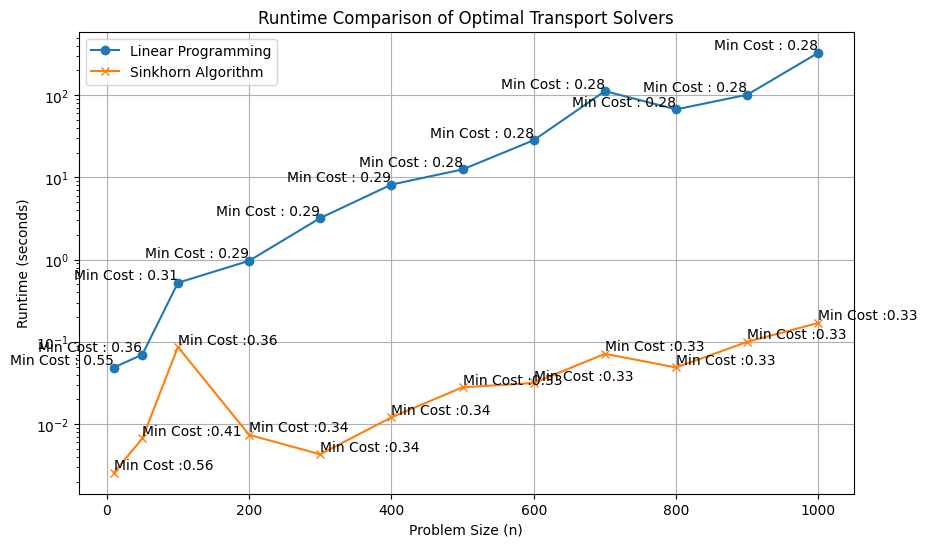

In [15]:
# Compare runtime for both method
sizes = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ]
linear_runtimes = []
sinkhorn_runtimes = []
linear_costs = []
sinkhorn_costs = []


for i in sizes :

  C, s, d = generate_random_instance(i)

  linear_values = linear_solver(C, s, d)
  linear_runtimes.append(linear_values[2])
  linear_costs.append(linear_values[1])

  sinkhorn_value = Sinkhorn_solver(C, s, d)
  sinkhorn_runtimes.append(sinkhorn_value[2])
  sinkhorn_costs.append(sinkhorn_value[1])

  


plt.figure(figsize=(10, 6))
for i, size in enumerate(sizes):
    plt.text(size, linear_runtimes[i], f'Min Cost : {linear_costs[i]:.2f}', ha='right', va='bottom')
    plt.text(size, sinkhorn_runtimes[i], f'Min Cost :{sinkhorn_costs[i]:.2f}', ha='left', va='bottom')


plt.plot(sizes, linear_runtimes, label='Linear Programming', marker='o')
plt.plot(sizes, sinkhorn_runtimes, label='Sinkhorn Algorithm', marker='x')
plt.yscale('log')
plt.xlabel('Problem Size (n)')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime Comparison of Optimal Transport Solvers')
plt.legend()
plt.grid(True)
plt.show()
